In [45]:
%pip install fastbook

Note: you may need to restart the kernel to use updated packages.


## Computer Vision
* Object recognition - recognize what items are in an image
* Object detection - where objects are in an image (segmentation is a subset of this)
* Out-of-domain data are unexpected images that arise in your data which are not relevant to the problem set

## The Drivetrain Approach

A methodology to ensure your modeling work is useful in practice. The goal of the Drivetrain Approach is to produce actionable outcomes. 

Here's the steps to the approach, if we were building search:

1. **Defined objective**: what outcome am I trying to achieve? 

    Eg; "What is the user's main objective in typing in a search query?". The answer to this would be showing them the most relevant search result

2. **Levers**: what inputs can I control? 

    Eg; ranking the search results is an action we can take

3. **Data**: what data can I collect?

    Eg; Information regarding which pages linked to which other pages - data that needs to be collected

4. **Models**: how the levers influence the objective.

    Eg; Take the levers and any uncontrollable variables as inputs - outputs can be combined to predict the final state for our objective



In [2]:
from fastcore.all import *
from fastbook import *
from fastdownload import download_url

url = search_images_ddg('toy gun', max_images=1)

dest = 'test_toy.jpg'
download_url(url[0], dest)

Path('test_toy.jpg')

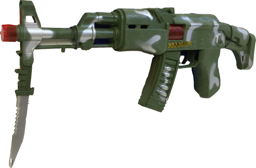

In [3]:
from fastai.vision.all import *

test_image = Image.open(dest)
test_image.to_thumb(256, 256)

In [4]:
labels = 'paintball', 'real', 'toy'
num_images = 100

path = Path('weapon_images')

In [ ]:
for x in labels:
    dest = (path/x)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images_ddg(f"{x} gun", max_images=num_images))

In [80]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

11

In [5]:
guns = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed = 10),
    get_y = parent_label,
    item_tfms=Resize(256)
)

dls = guns.dataloaders(path)

/home/abhay/miniconda3/envs/fastai/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


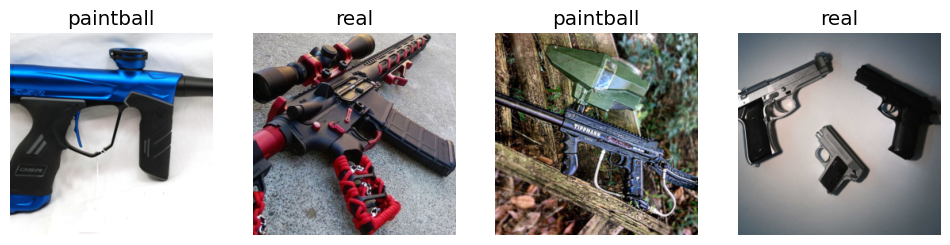

In [6]:
dls.valid.show_batch(max_n=4, nrows=1)

## Resize Methods

### ResizeMethod.Squish

Squishes the image to fit into the desired size. 

Pros: shows the entire image

Cons: distorts various features

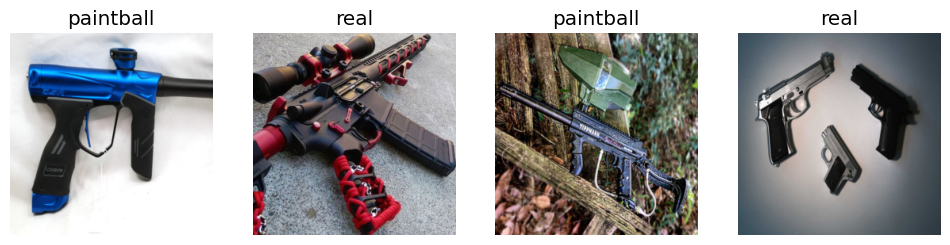

In [7]:
guns = guns.new(item_tfms=Resize(256, ResizeMethod.Squish))
dls = guns.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

### ResizeMethod.Pad

If the image is too large it pads the area with black to help it fit into the desired size

Pros: Entire image with feature distortion

Cons: wasted compute 

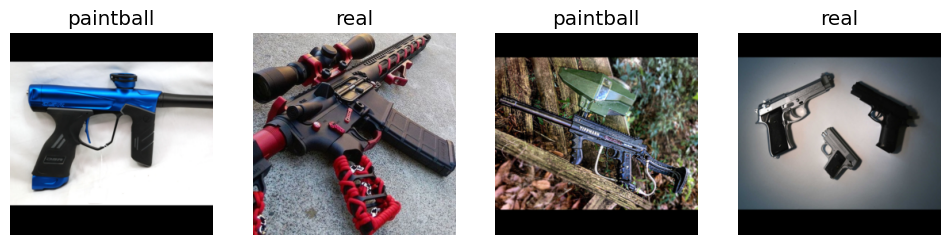

In [8]:
guns = guns.new(item_tfms=Resize(256, ResizeMethod.Pad, pad_mode='zeros'))
dls = guns.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

### RandomResizedCrop

A neural network can't tell you've given it the same photo if it's slightly cropped - this is important because you can then randomly crop the same photo a few times and it will take it in as new training data. 

This is a best-practice.

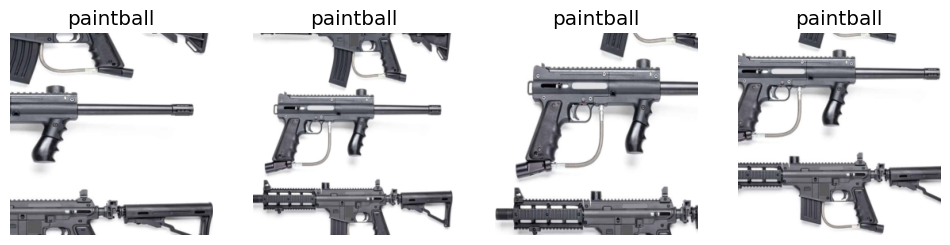

In [9]:
guns = guns.new(item_tfms=RandomResizedCrop(256, min_scale=0.3))
dls = guns.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

## Data Augmentation

Data augmentations refers to creating random variations of our input data so that it appears different but does not change the meaning of the data.

Examples of data augmentation are flipping, rotating, perspective warping, brightness changes, and contrast changes.

fastai can augment your data batches using `batch_tfms=aug_transforms` (`mult` just increases the effect).   

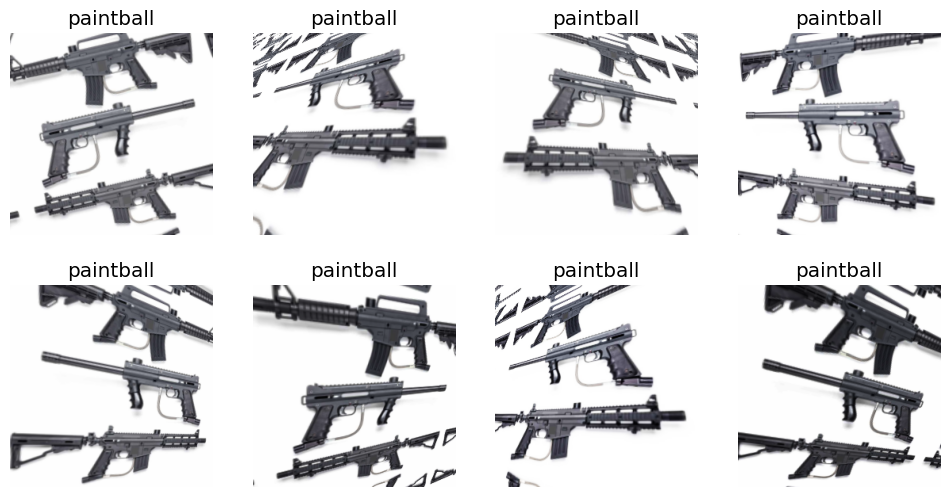

In [10]:
guns = guns.new(item_tfms=Resize(256), batch_tfms=aug_transforms(mult=2))
dls = guns.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

You can see below that using `RandomResizedCrop` for each image and then augmenting each batch with `aug_tranforms` is a best practice for your data.

In [11]:
guns = guns.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.3),
    batch_tfms=aug_transforms()
)

dls = guns.dataloaders(path)

In [12]:
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(4)

epoch,train_loss,valid_loss,accuracy,time
0,1.654702,1.149424,0.581818,00:33


epoch,train_loss,valid_loss,accuracy,time
0,1.179951,0.608207,0.709091,00:10
1,1.038354,0.316603,0.818182,00:08
2,0.875196,0.264297,0.872727,00:07
3,0.829212,0.236853,0.872727,00:07


## Cleaning our Data

Now that we've seen our model's performance, we can analyze which images it's performing poorly on and identify if we can **clean** the data to fix this.


### ClassificationInterpretation

This is a class that has a few helpful tools that'll let us figure out what's going wrong.

`.plot_confusion_matrix()` is a very useful element in this class which lets us see the # of images being predicted incorrectly (and in which categories) based on our validation set.

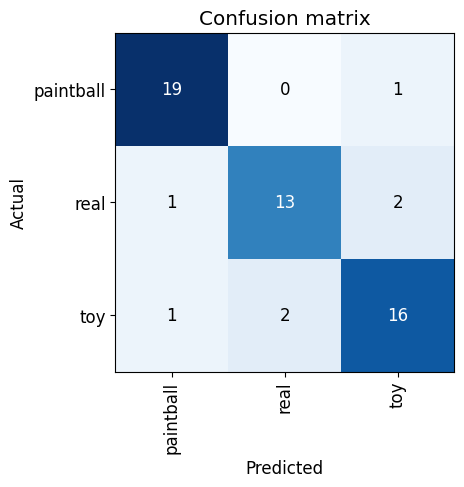

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Eg; we see in the above that there were 3 cases where the model predicted that a real gun was a paintball gun. 

### Plot Top Losses

This lets us see which images specifically the model struggled on the most.

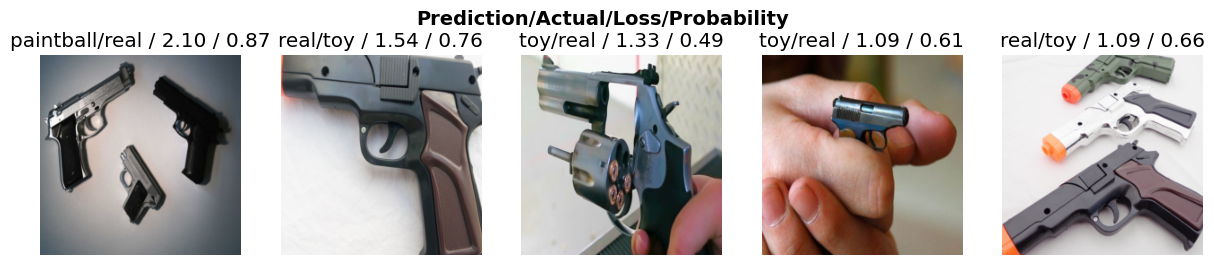

In [14]:
interp.plot_top_losses(5, nrows=1)

Eg; it got the first image wrong (even though it was extremely confident in it being a real gun - hence the high loss) because it was very certain that was a real gun but it turned out to be a toy - likely because the orange muzzle is cropped out in the original photo making it hard to tell. This might be an example of a photo that we remove to stop it from confusing the model.

### ImageClassifierCleaner

A useful function that opens up a GUI where we can go through the images in the train and validation sets of each category and either remove them or reorganize them to a different category if we see fit. 

In [15]:
from fastai.vision.widgets import ImageClassifierCleaner

cleaner = ImageClassifierCleaner(learn)
cleaner

/home/abhay/miniconda3/envs/fastai/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


The GUI won't implement the changes - it just stores the actions we want to do. 

We use the following loops to delete the images flagged as remove and to re-organize the images flagged to be put into a different category. 

In [16]:
for idx in cleaner.delete():
    cleaner.fns[idx].unlink()

for idx, cat in cleaner.change():
    shutil.move(str(cleaner.fns[idx]), path/cat)

Now we see that the model performs much better and makes less mistakes!

In [17]:
learn.fine_tune(4)

epoch,train_loss,valid_loss,accuracy,time


/home/abhay/miniconda3/envs/fastai/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,accuracy,time
0,0.542143,0.179836,0.927273,00:07
1,0.512849,0.157942,0.963636,00:08
2,0.453618,0.152987,0.963636,00:07
3,0.430084,0.147182,0.981818,00:07


/home/abhay/miniconda3/envs/fastai/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/abhay/miniconda3/envs/fastai/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/abhay/miniconda3/envs/fastai/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/abhay/miniconda3/envs/fastai/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/home/abhay/miniconda3/envs/fastai/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


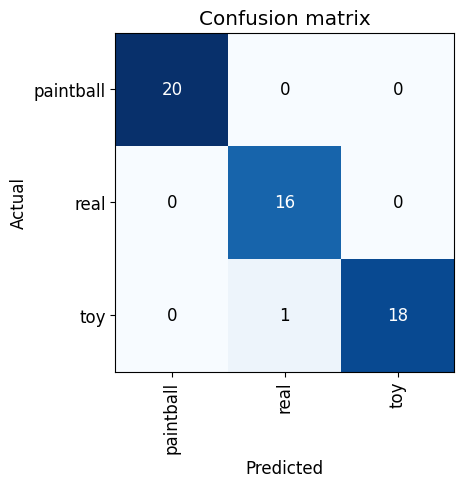

In [18]:
interp.plot_confusion_matrix()

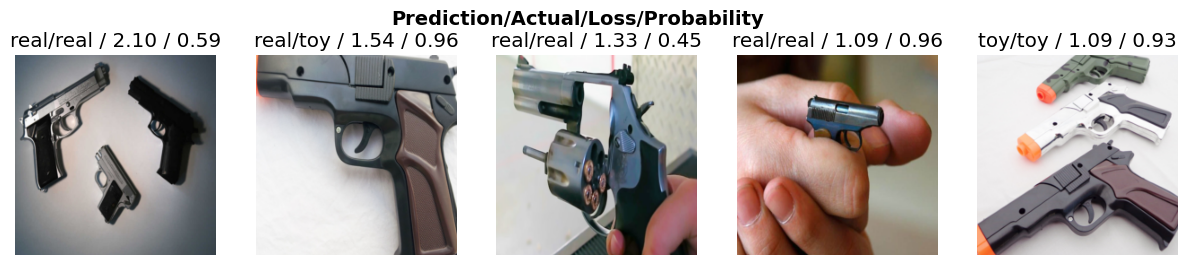

In [19]:
interp.plot_top_losses(5, nrows=1)

## Exporting & Using Model for Inference

We can use the `export` method to save the model **architecture** and the **parameters** to be used for inference in other applications.

Here of course it doesn't matter since we're working in the same notebook with the model present but the below gives an example of how this would be accessed in a different application.

In [20]:
learn.export()

In [31]:
learn_inf = load_learner('export.pkl')

test_image = Image.open('test_toy.jpg').to_thumb(256, 256)

learn_inf.predict(test_image)

('toy', tensor(2), tensor([1.8461e-01, 5.9950e-04, 8.1479e-01]))

In [32]:
learn_inf.dls.vocab

['paintball', 'real', 'toy']

In [33]:
label, _, probs = learn_inf.predict(test_image)

print(f"Confidence in this image being a {label}: {probs.max() * 100}%")

Confidence in this image being a toy: 81.47901153564453%


## Creating a Notebook App

In [67]:
from ipywidgets import *

In [68]:
# File upload widget
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [69]:
img = PILImage.create(btn_upload.data[-1])

In [70]:
out_pl = widgets.Output()
out_pl.clear_output()

with out_pl: display(img.to_thumb(256, 256))
out_pl

Output()

In [57]:
pred, pred_idx, probs = learn_inf.predict(img)

lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}' # could also do probs.max()
lbl_pred

Label(value='Prediction: real; Probability: 0.9996')

In [71]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [72]:
# Combining all the lines of code above into a click event handler

def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred, pred_idx, probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [73]:
btn_upload = widgets.FileUpload()

In [74]:
VBox([widgets.Label('Select an image'), 
    btn_upload, btn_run, out_pl, lbl_pred])

## Deploying Your App

The code above makes it pretty clear that you can use an exported model and ipywidgets to create your own GUI for an app.

Deploying your app, you can use **Voila** to convert your notebook into a standalone app and services like **HuggingFace Spaces** to host (although HuggingFace Spaces also makes it easy to create a GUI and frontend).

A GPU Is not needed to serve your model in production. Why?
* You'll only be classifying one image at a time, so a GPU which is built for doing work in parallel isn't going to be as cost-effective as a CPU for something like this.
* It's also complicated to deal with GPU inference and memory. 
* CPU servers are cheaper.

You can use different services & libraries to deploy you application onto mobile devices or Raspberry Pis. Although the easiest solution is to have your model available on a server that can be accessed by your device. 

**Horizontal Scaling**: When each user is bringing their own compute resources (models running locally) which helps to scale with an increasing number of users. 

## Avoiding Disaster with ML Applications

The fastai won't go too in-depth on this but [Building Machine Learning Powered Applications](http://shop.oreilly.com/product/0636920215912.do) by Emmanuel Ameisen (O'Reilly) is a good book on this topic.

The most difficult part of ML applications compared to traditional software deployment is the uncertainty - being ready for seeing data that is not exactly defined in your scope, unsure of how your model may react to that. This is an example of the more general problem of **out-of-domain data** (data is production is different from data seen in training). There is no *technical solution* to this problem.

Another common problem is **domain shift**: the type of data the model sees changes over time so the original training data is no longer relevant. 

Here's a risk-mitigation process to minimize the impact of these problems arising:

<img src="risk_mitigation.png" width="500"/>

1. Where possible, use a manual process with your DL approach running in parallel but not driving actions. 
    * Cross-reference to the DL to see if it's performing well
2. Limit the scope of deployment, where a highly constrained deployment occurs
    * Small geography, time-constrained - essentially a small-scale pilot.
3. Gradually increase the scope of the pilot/rollout
    * They key here is to have really good reporting systems in place to always be up to date with any changes that need to be made. 
    * Think about everything that could go wrong with the system and how you can measure or report if those things are happening. 


## Unforeseen Consequences and Feedback Loops

This goes back to the idea of a predictive policing model which may create a negative feedback loops. 

A good thought exercise to understand if your model may have negative feedback loops is - *"What would happen if the model had extremely high predictive power and worked really well?"*. What influence would this create? Who would be most impacted? What would extreme results look like?

## Questionnaire 

1. Provide an example of where the bear classification model might work poorly in production, due to structural or style differences in the training data.

* You're taking in video data instead of images and the image quality is lower. 
* The bear is in awkward positions like behind a bush or turned around which isn't found in your training set.

2. Where do text models currently have a major deficiency?

* Providing accurate and correct answers (they're good at context-appropriate text) - seen this with Google's Gemini

3. What are possible negative societal implications of text generation models?

* Misinformation & biases - seeing this a lot lately with LLMs.

4. In situations where a model might make mistakes, and those mistakes could be harmful, what is a good alternative to automating a process?

* Keep human review as part of the process - everything is still double-checked by a human.
* However, allow models to flag things that are high priority (predictions it is very confident in) to accelerate the review of those.

5. What kind of tabular data is deep learning particularly good at?

* Tabular data that includes natural language or high cardinality categorical columns (contains a large number of unique values - eg; User ID column)

6. What's a key downside of directly using a deep learning model for recommendation systems?

* Only indicates something that a user might like - not what would be helpful.
* Eg; Amazon recommending all books from the same author or the exact same book just in a different packaging or format.

7. What are the steps of the Drivetrain Approach?

* Defined Objective
* Levers
* Data
* Modeling

8. How do the steps of the Drivetrain Approach map to a recommendation system?

* Discussed in earlier section of my notes.

9. Create an image recognition model using data you curate, and deploy it on the web.

10. What is DataLoaders?

* The class that passes data to the fastai model
* Essentially a class that stores the required Dataloader objects (for training and validation sets)

11. What four things do we need to tell fastai to create DataLoaders?

* what kind of data are we working with - `blocks=`
* how to get the list of items - `get_items=`
* how to create the validation set - `splitter=`
* how to label these items - `get_y=`

12. What does the splitter parameter to DataBlock do?

* Splits the data into a training and validation set.
* Can be used to do random splits.

13. How do we ensure a random split always gives the same validation set?

* Use the same seed. 

14. What letters are often used to signify the independent and dependent variables?

* x & y

15. What's the difference between the crop, pad, and squish resize approaches? When might you choose one over the others?

* Crop - crops the photo to fit size constraints
* Pad - adds black bars where needed to get the whole image to fit size constraints
* Squish - squishes the image to fit size constraints
* The best thing to use is `RandomResizedCrop` which will randomly select a region of an image to crop so every epoch the model sees something new. 

16. What is data augmentation? Why is it needed?

* Data augmentation refers to creating random variations of our input data, such that they appear different, but not so different that it changes the meaning of the data.
* Data augmentation is useful for the model to better understand the basic concept of what an object is and how the objects of interest are represented in images - it allows ML models to *generalize*.

17. What is the difference between item_tfms and batch_tfms?

* item_tfms applies to all the items in the train/validation set
* batch_tfms is only applied to the training batches 

18. What is a confusion matrix?

* A matrix that shows where the model is making mistakes w.r.t it's predictions vs. what the image actually is

19. What does export save?

* The model architecture and parameters

20. What is it called when we use a model for getting predictions, instead of training?

* Inference

21. What are IPython widgets?

* Creates GUIs by combining JS and Python that allow you to interact with your code

22. When might you want to use CPU for deployment? When might GPU be better?

* CPU if you're only handling one image at a time from a user for better compute
* GPU if you're computing a batch of images submitted by multiple users

23. What are the downsides of deploying your app to a server, instead of to a client (or edge) device such as a phone or PC?

* Requires a network connection and there will be increased latency. Also, privacy concerns.
* However, deploying to a server makes it easy to iterate and rollout new updates. 

24. What are three examples of problems that could occur when rolling out a bear warning system in practice?

* Night-time images
* Low resolution
* Predictions are returned too slowly to be useful

25. What is "out-of-domain data"?

* Data that is fundamentally different in some way from the model's training data.

26. What is "domain shift"?

* The data required for the model to be valuable changes over time and the training data slowly becomes irrelevant.\

27. What are the three steps in the deployment process?

* Manual Process
* Limited Scope Deployment
* Gradual Expansion